In [45]:
######## MODULES ##########
import re
import numpy as np
import matplotlib.pyplot as plt
import celia_functions as cf
plt.rcParams.update({'font.size':14, "xtick.direction":"in", "ytick.direction":"in"})
#np.set_printoptions(threshold=sys.maxsize)

pyro_channels = ["Ch1","Ch2","Ch3","Ch4"] # Establishing a catagory of diagnostics will be helpful later.

In [46]:
shotsheet = cf.read_metadata(["SHOT #","Target X","Target Z","TARGET NUMBER","Laser Energy (before comp) [J]"])
targetsheet = cf.read_metadata(["Number","Wheel"])

for key in shotsheet.keys():
    shotsheet[key] = [np.nan if re.search('[^\d.]', str(value)) else float(value) for value in shotsheet[key]] # Filter out all numberic characters. Numeric characters being: `0123456789.`

row_has_data = ~np.all(np.isnan(cf.transform_list(shotsheet.values())), axis = 1)
shotsheet = {key: [cell for cell, cell_has_data in cf.transform_list((column, row_has_data)) if cell_has_data] for key, column in shotsheet.items()} # Filter out any rows that don't have any entries. (all nan rows)

shotsheet["Wheel"] = [targetsheet["Wheel"][targetsheet["Number"].index(target_number)] if target_number in targetsheet["Number"] else np.nan for target_number in shotsheet["TARGET NUMBER"]] # give each target it's respective wheel.
shotsheet["SHOT #"] = [int(shot) for shot in shotsheet["SHOT #"]] #make all shots into intergers. Will fail if there is a nan value.



In [47]:
###Initialisation
target = 0
shotsheet["relative X"] = np.full(len(shotsheet["SHOT #"]), fill_value= np.nan)
shotsheet["relative Z"] = np.full(len(shotsheet["SHOT #"]), fill_value= np.nan)
###Loop over all shots
for shot in shotsheet["SHOT #"]:
    s = shotsheet["SHOT #"].index(shot) #find the corrisponding index for this shot. Should be shot -1 = s.
    if shotsheet["TARGET NUMBER"][s] != target:
        delta_x = shotsheet["Target X"][s]
        delta_z = shotsheet["Target Z"][s]
        target = shotsheet["TARGET NUMBER"][s] # ASSUMES THAT WE DON'T RETURN BACK TO THE SAME TARGET.

    shotsheet["relative X"][s] = shotsheet["Target X"][s] -delta_x #make the target movement in x relitive to the first shot
    shotsheet["relative Z"][s] = shotsheet["Target Z"][s] -delta_z #make the target movement in z relitive to the first shot

shotsheet["d"] = np.linalg.norm([shotsheet["relative X"], shotsheet["relative Z"]], axis= 0) # pythagorus to find d. This might be a little simplistic since we know the angle should be 25°

### Choose which targets and channels to use here!

In [48]:
pyro_background = {"Ch1": [90,105,106],
                   "Ch2": [66,67,69,81,86]}

diagnostics = {"Ch2": [105,106],
               "Ch3": [66,67,69,90,105,106],
               "Ch4": [66,67,69,86],
               "bdot": [66,67,69,86,90,105,106],
               "xray": [66,67,69,86,90,105,106],
               "energy": [66,67,69,86,90,105,106]}

background_lookup = {t: ch for ch, target in pyro_background.items() for t in target} #Create a target -> channel lookup table.
background_lookup = {shot: ch for shot, s in enumerate(shotsheet["SHOT #"]) for t, ch in background_lookup.items() if shotsheet["TARGET NUMBER"][s] == t} #Convert to a shot -> channel lookup table.
pyro_background_shots = {ch: [shot for t in target for shot, s in enumerate(shotsheet["SHOT #"]) if shotsheet["TARGET NUMBER"][s] == t] for ch, target in pyro_background.items()} #find the respective shots for these targets. Include both pyro emp and osc emp data mearly to ensure that has the same indexes as the next dictionary
diagnostics_shots = {ch: [shot for t in target for shot, s in enumerate(shotsheet["SHOT #"]) if shotsheet["TARGET NUMBER"][s] == t] for ch, target in diagnostics.items()} #find the respective shots for these targets. Include both the target and emp data

background_data = cf.read_diagnostic_data(pyro_background_shots, silent= True)
diagnostic_data = cf.read_diagnostic_data(diagnostics_shots, silent= True)

### Background subtraction
Comment this out to remove background subtraction. Only `active_pyro_channels` will be background subtracted. 

In [49]:
active_pyro_channels = np.intersect1d(pyro_channels, list(diagnostic_data.keys()))
for ch in active_pyro_channels:
    for shot in shotsheet["SHOT #"]:
        try:
            diagnostic_data[ch][diagnostic_data["shot"].index(shot)] = np.subtract(diagnostic_data[ch][diagnostic_data["shot"].index(shot)], background_data[background_lookup[shot]][background_data["shot"].index(shot)])
        except:
            continue

### Calculate signal level for the diagnostics
The diagnostic data within `diagnostic_data` also gets merged with the metadata within `shotsheet`.

In [50]:
diagnostic_data["bdot"] = [np.array(reading)[~np.isinf(reading)] for reading in diagnostic_data["bdot"]] #Somehow the bdot data has infinities in it.

for key in diagnostic_data.keys():
    if key == "shot": #don't add another shot number to the shotsheet.
        continue 

    if key in pyro_channels:
        diagnostic_data[key] = [np.abs(np.nanmin(reading)) for reading in diagnostic_data[key]] #find the minima of every pyro channel
    elif key == "bdot":
        diagnostic_data[key] = [np.ptp(shot) for shot in diagnostic_data[key]] #find the range of every bdot
    elif key == "xray":
        diagnostic_data[key] = [cf.estimate_xray_signal(shot, silent= True) for shot in diagnostic_data[key]] #estimate the signal level of every xray photo.

    shotsheet[key] = [diagnostic_data[key][diagnostic_data["shot"].index(shot)] if shot in diagnostic_data["shot"] else np.nan for shot in shotsheet["SHOT #"]] #add diagnostics to the shotsheet on respective shot numbers

C:\Users\syf83691\AppData\Local\Temp\ipykernel_11868\3038362699.py:8: RuntimeWarning: All-NaN slice encountered
  diagnostic_data[key] = [np.abs(np.nanmin(reading)) for reading in diagnostic_data[key]] #find the minima of every pyro channel
C:\Users\syf83691\AppData\Local\Temp\ipykernel_11868\3038362699.py:8: RuntimeWarning: All-NaN axis encountered
  diagnostic_data[key] = [np.abs(np.nanmin(reading)) for reading in diagnostic_data[key]] #find the minima of every pyro channel


### Reorganise data by target
The reorganised data is saved in a new dictionary called `dataset`.

In [51]:
### initialise
dataset = {}
dataset["d"] = [[shotsheet["d"][s] for s, shot in enumerate(shotsheet["SHOT #"]) if shotsheet["TARGET NUMBER"][s] == target] for target in np.unique(shotsheet["TARGET NUMBER"])] # displacement must also be initialised because it determines which data sets are valid

### loop over all other data sets
for key in shotsheet.keys():
    if key != "d":
        dataset[key] = [[shotsheet[key][s] for s, shot in enumerate(shotsheet["SHOT #"]) if shotsheet["TARGET NUMBER"][s] == target] for target in np.unique(shotsheet["TARGET NUMBER"])] #change shape so that shots on the same target are grouped together
        dataset[key] = [target for t, target in enumerate(dataset[key]) if len(dataset["d"][t]) > 0] #filter out targets with no displacement data. (targets that were never shot)
    if key in ["TARGET NUMBER","Wheel"]:
        dataset[key] = [target[0] for target in dataset[key]] #these do not change when the target number is constant. Remove list.

### finalise
dataset["d"] = [target for target in dataset["d"] if len(target) > 0]

### Normalisation
Comment out line 3 to stop energy normalisation. Comment out line 4 to stop normalisation to the first shot on the target.

In [52]:
### loop over all channels
for ch in diagnostics.keys(): #loop over all diagnostic data
    dataset[ch] = [np.array(target)/np.array(dataset["Laser Energy (before comp) [J]"][n]) for n, target in enumerate(dataset[ch])] #normalise all channels for laser energy
    #dataset[ch] = [np.array(target)/np.nanmean(target) for target in dataset[ch]] #normalise all channels such that their average is 1.
    dataset[ch] = [np.array(target)/target[0] if ~np.isnan(target[0]) else np.array(target) for target in dataset[ch]] #normalise all channels such that they start on 1 (or np.nan).

### Setup parameters for graph

In [53]:
### best fit parameters
number_of_points = 100 #number of points for the best fit line.
#rolling_width = 0.35 #half width. only used by roll_average
confidence= 0.05 #only used by polynomial_fit

x0 = {"pyro": [1],
      "bdot": [1],
      "energy": [1],
      "xray": [1]}

constraints = {"pyro": None, #[[lower], [upper]]
               "bdot": None, #scipy least_squares doesn't support equality constraints for some reason.
               "energy": None,
               "xray": None}

model= cf.inverse_square

In [54]:
diagnostics.keys()

dict_keys(['Ch2', 'Ch3', 'Ch4', 'bdot', 'xray', 'energy'])

### Calculate best fit

In [55]:
fit_x, fit_y, fit_delta = {}, {}, {}

### best fit
fit_x["pyro"], fit_y["pyro"], fit_delta["pyro"] = cf.polynomial_fit([dataset["d"] for ch in active_pyro_channels],
                                                                [dataset[ch] for ch in active_pyro_channels],
                                                                number_of_points= number_of_points,
                                                                x0= x0["pyro"],
                                                                constraints= constraints["pyro"],
                                                                confidence= confidence,
                                                                model_function= model)

#The remaining diagnostic fits can be done in a loop

for diagnostic in diagnostics.keys():
    if diagnostic in pyro_channels:
        continue
    #else:
    fit_x[diagnostic], fit_y[diagnostic], fit_delta[diagnostic] = cf.polynomial_fit(dataset["d"],
                                                                                dataset[diagnostic],
                                                                                number_of_points= number_of_points,
                                                                                x0= x0[diagnostic],
                                                                                constraints= constraints[diagnostic],
                                                                                confidence= confidence,
                                                                                model_function= model)
    

Optimal coeffients:
7.370354186416782
Optimal coeffients:
29.238874473422836
Optimal coeffients:
24574.0
Optimal coeffients:
17.315118696679463


C:\Users\syf83691\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\delta_method.py:135: RuntimeWarning: divide by zero encountered in scalar divide
  MSR = SSR / (np.size(popt)-1)              # mean square (regression model)


### Graph itslef

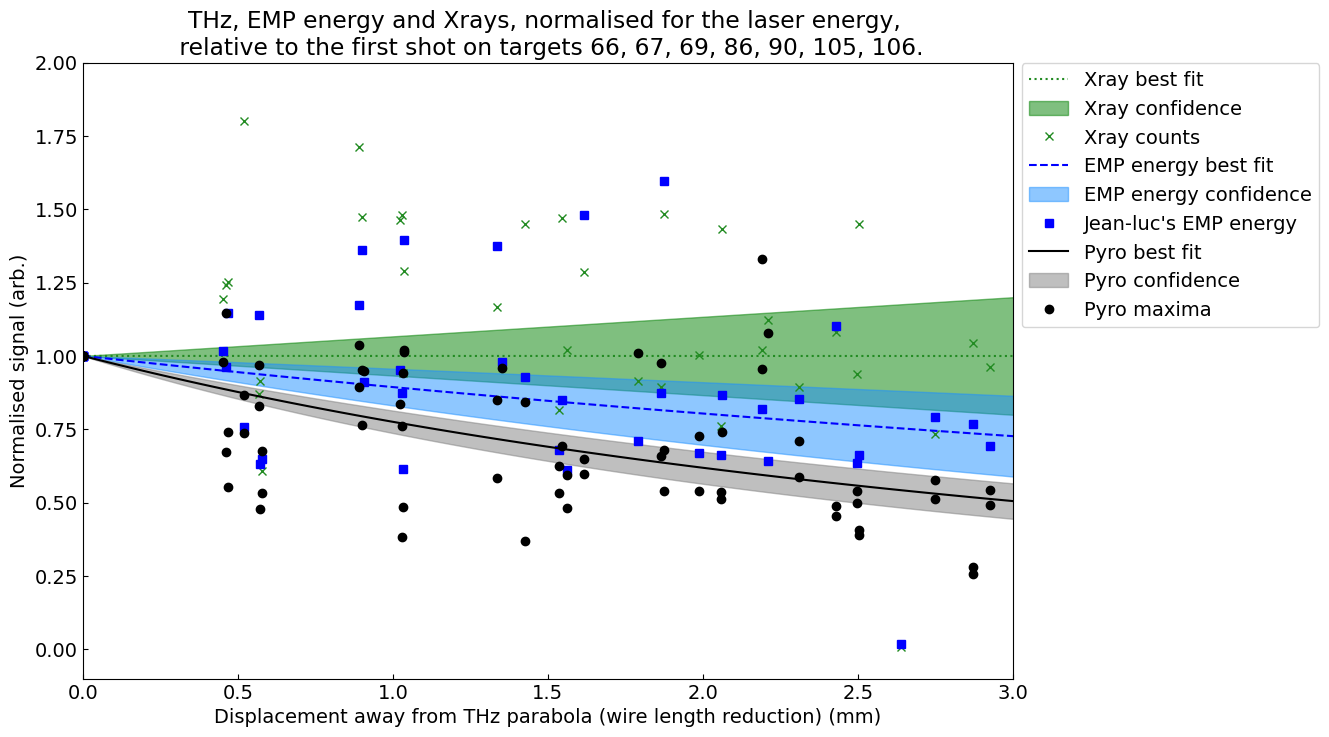

In [56]:
fig, axs = plt.subplots(1, 1, figsize= (12,8))

### PLOT XRAY
# xray best fit
axs.plot(fit_x["xray"],
        fit_y["xray"],
        color= "forestgreen",
        linestyle= ":",
        label= "Xray best fit")
# Xray best fit uncertainty
axs.fill_between(fit_x["xray"],
                fit_delta["xray"]['lwr_conf'],
                fit_delta["xray"]['upr_conf'],
                color= "green",
                alpha= 0.5,
                label= "Xray confidence")
# Xray datapoints
axs.plot(cf.flatten_list(dataset["d"]),
        cf.flatten_list(dataset["xray"]),
        color= "forestgreen",
        linestyle= "None",
        marker= "x",
        label= "Xray counts")
### PLOT ENERGY
# energy best fit
axs.plot(fit_x["energy"],
        fit_y["energy"],
        color= "blue",
        linestyle= "--",
        label= "EMP energy best fit")
# energy best fit uncertainty
axs.fill_between(fit_x["energy"],
                fit_delta["energy"]['lwr_conf'],
                fit_delta["energy"]['upr_conf'],
                color= "dodgerblue",
                alpha= 0.5,
                label= "EMP energy confidence")
# energy datapoints
axs.plot(cf.flatten_list(dataset["d"]),
        cf.flatten_list(dataset["energy"]),
        color= "blue",
        linestyle= "None",
        marker= "s",
        label= "Jean-luc's EMP energy")
"""### PLOT BDOT
# bdot best fit
axs.plot(fit_x["bdot"],
        fit_y["bdot"],
        color= "crimson",
        linestyle= "-.",
        label= "Bdot ptp best fit")
# bdot best fit uncertainty
axs.fill_between(fit_x["bdot"],
                fit_delta["bdot"]['lwr_conf'],
                fit_delta["bdot"]['upr_conf'],
                color= "red",
                alpha= 0.5,
                label= "Bdot ptp confidence")
# bdot datapoints
axs.plot(cf.flatten_list(dataset["d"]),
        cf.flatten_list(dataset["bdot"]),
        color= "red",
        linestyle= "None",
        marker= "^",
        label= "Bdot peak to peak")"""
### PLOT PYRO
# pyro best fit
axs.plot(fit_x["pyro"],
        fit_y["pyro"],
        color= "k",
        label= "Pyro best fit")
# pyro best fit uncertainty
axs.fill_between(fit_x["pyro"],
                fit_delta["pyro"]['lwr_conf'],
                fit_delta["pyro"]['upr_conf'],
                color= "gray",
                alpha= 0.5,
                label= "Pyro confidence")
# pyro datapoints
axs.plot(cf.flatten_list([dataset["d"] for ch in active_pyro_channels]),
        cf.flatten_list([dataset[ch] for ch in active_pyro_channels]),
        color= "k",
        marker = "o",
        linestyle= "None",
        label= "Pyro maxima")

targets = np.unique(cf.flatten_list(diagnostics.values()))
axs.set(xlabel= "Displacement away from THz parabola (wire length reduction) (mm)", # x axis label
        ylabel= "Normalised signal (arb.)", # y axis label
        xlim= (0, 3), # x limits
        ylim= (-0.1, 2), #y limits
        title= "THz, EMP energy and Xrays, normalised for the laser energy, \n relative to the first shot on targets " + ", ".join(targets.astype(str)) + ".") #title

axs.legend(loc= "upper right", bbox_to_anchor= (1.34, 1.015)) # loc fixes the location of the legend. 

plt.show()